In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import arange, array

from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [2]:
from sklearn import ensemble, tree
from sklearn.svm import SVR
import xgboost as xgb

In [3]:
housing = pd.read_csv('data/size_trimmed.csv')
housing.shape

(2523, 86)

In [4]:
housing.head()

,GrLivArea,MSSubClass,LotFrontage,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,GarageSize,Remodel_binary,LotPercent,Neighborhood_Num,Remodel_Qual,Remodel_GrLiv,Remodel_Bath,Remodel_Kitch,SalePrice,Log_SalePrice
0,856,1S_1945older,58.800593,6,6,1939,0.0,238.0,0.0,618.0,856.0,856,0,0,1.0,0.0,1,0,2,1,4,1,1939.0,399.0,0,0,0,0,166,0,0,3,2010,RL,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,TA,Y,SBrkr,TA,Typ,Gd,Detchd,Unf,TA,TA,Y,None,None,None,WD,Normal,large,1,0.108492,17,6,856,1,TA,126000,11.744037
1,1049,1S_PUD,42.000000,5,5,1984,149.0,552.0,393.0,104.0,1049.0,1049,0,0,1.0,0.0,2,0,2,1,5,0,1984.0,266.0,0,105,0,0,0,0,0,2,2009,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,1Story,Gable,CompShg,HdBoard,HdBoard,BrkFace,Gd,TA,CBlock,Gd,TA,Mn,GLQ,ALQ,GasA,TA,Y,SBrkr,Gd,Typ,None,Attchd,Fin,TA,TA,Y,None,None,None,WD,Normal,small,0,0.247698,7,0,0,0,NaN,139500,11.845820
2,1001,1S_1945older,60.000000,5,9,1930,0.0,737.0,0.0,100.0,837.0,1001,0,0,0.0,0.0,1,0,2,1,5,0,1930.0,216.0,154,0,42,86,0,0,0,11,2007,C (all),Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,None,Gd,TA,BrkTil,TA,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Detchd,Unf,TA,Po,N,None,None,None,WD,Normal,small,1,0.165182,5,5,1001,1,Gd,124900,11.735269
3,1039,2S_1945older,80.000000,4,8,1900,0.0,0.0,0.0,405.0,405.0,717,322,0,0.0,0.0,1,0,2,1,6,0,1940.0,281.0,0,0,168,0,111,0,0,5,2009,RL,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,Gable,CompShg,MetalSd,MetalSd,None,Gd,Gd,BrkTil,Fa,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,TA,Typ,None,Detchd,Unf,TA,TA,N,None,None,None,WD,Normal,small,1,0.088019,12,4,1039,1,TA,114000,11.643954
4,1665,2S_1946newer,70.000000,8,6,2001,0.0,643.0,0.0,167.0,810.0,810,855,0,1.0,0.0,2,1,3,1,6,0,2001.0,528.0,0,45,0,0,0,0,0,11,2009,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,Fin,TA,TA,Y,None,None,None,WD,Normal,large,0,0.096429,23,0,0,0,NaN,227000,12.332705


## Pipeline

In [5]:
price = housing['SalePrice']
features = housing.drop(["SalePrice", 'Log_SalePrice'], axis=1)

cat_cols = features.select_dtypes(include = object).columns

le = LabelEncoder()
for col in features[cat_cols]:
    features[col]= le.fit_transform(features[col])

In [6]:
feature_sets = {
    "Original_features": features
}

target_sets = {
    "SalePrice": housing['SalePrice'],
    "Log_SalePrice": housing['Log_SalePrice']
}

In [7]:
tree_pipe = Pipeline(
    steps=[
        ("regressor", tree.DecisionTreeRegressor())]
)

forest_pipe = Pipeline(
    steps=[
        ("regressor", ensemble.RandomForestRegressor())]
)

bagging_pipe = Pipeline(
    steps=[
        ("regressor", ensemble.BaggingRegressor())]
)

gradient_pipe = Pipeline(
    steps=[
        ("regressor", ensemble.GradientBoostingRegressor())]
)

models = {'DecisionTree': tree_pipe,
          'Forest': forest_pipe,
          'Bagging': bagging_pipe,
          'Gradient': gradient_pipe
          }

In [8]:
def test(models):
    
    cross_val_r2 = []
    cross_val_error = []
    mod_details = []
    
    for m in models:
        for f in feature_sets:
            for t in target_sets:
                X = feature_sets[f]
                y = target_sets[t]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
                cross_val_error.append(cross_val_score(models[m], X_train, y_train, 
                                                      scoring='neg_root_mean_squared_error').mean())
                cross_val_r2.append(cross_val_score(models[m], X_train, y_train, 
                                                   scoring='r2').mean())
                mod_details.append(str(m) + '_' + str(f) + '_' + str(t))
        
    results = pd.DataFrame(
                {'CV R^2': cross_val_r2,
                 'CV Error': cross_val_error
                }, index = mod_details
            )
    
    return results

test(models)

,CV R^2,CV Error
DecisionTree_Original_features_SalePrice,0.759001,-33815.657730
DecisionTree_Original_features_Log_SalePrice,0.746057,-0.195919
Forest_Original_features_SalePrice,0.900326,-21793.454956
Forest_Original_features_Log_SalePrice,0.880575,-0.128533
Bagging_Original_features_SalePrice,0.885175,-23352.788240
Bagging_Original_features_Log_SalePrice,0.859599,-0.136324
Gradient_Original_features_SalePrice,0.919557,-19551.527421
Gradient_Original_features_Log_SalePrice,0.908338,-0.113005


## Tree Model

In [47]:
X = features
y = price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [51]:
grid_para_tree = [
    {
        "criterion": ["squared_error", "absolute_error"],
        "min_samples_leaf": range(1, 20)},
    {
        "criterion": ["squared_error", "absolute_error"],
        "min_samples_split": np.linspace(start=2, stop=30, num=29, dtype=int)}
]

tree_model = tree.DecisionTreeRegressor(random_state = 0)

grid_search_tree = GridSearchCV(tree_model, grid_para_tree, cv=5, scoring='r2')
grid_search_tree.fit(X_train, y_train)

print("The best parameters are: ", grid_search_tree.best_params_)
print("R^2 of the training set: ", grid_search_tree.score(X_train, y_train))
print("R^2 of the final model: ", grid_search_tree.score(X_test, y_test))

The best parameters are:  {'criterion': 'absolute_error', 'min_samples_leaf': 13}
R^2 of the training set:  0.8832994579154514
R^2 of the final model:  0.8324791198540912


In [54]:
feat_imp = pd.DataFrame(grid_search_tree.best_estimator_.feature_importances_, index=X.columns)
feat_imp.columns = ['imp']
feat_imp.sort_values('imp', ascending = False).head(10)

,imp
OverallQual,0.419816
TotalIndoorSF,0.350410
Neighborhood_Num,0.041558
1stFlrSF,0.019139
GarageArea,0.019109
KitchenQual,0.016430
YearBuilt,0.013568
GarageType,0.012722
LotArea,0.009240
BsmtUnfSF,0.009240


## Random Forest

In [96]:
# random forest

grid_para_RF = [
    {
        "n_estimators": [100, 300, 500],
        "max_features": ["sqrt", "log2", None],
        "min_samples_leaf": range(2, 10)
    }
]

RF = ensemble.RandomForestRegressor(random_state = 0)

grid_search_RF = GridSearchCV(RF, grid_para_RF, cv=3, scoring='r2', n_jobs = -1)
%time grid_search_RF.fit(X_train, y_train)

print("The best parameters are: ", grid_search_RF.best_params_)
print("R^2 of the training set: ", grid_search_RF.score(X_train, y_train))
print("R^2 of the final model: ", grid_search_RF.score(X_test, y_test))

CPU times: user 17.5 s, sys: 565 ms, total: 18 s
Wall time: 3min 50s
The best parameters are:  {'max_features': None, 'min_samples_leaf': 3, 'n_estimators': 500}
R^2 of the training set:  0.9664351837198302
R^2 of the final model:  0.9022525020552926


<Axes: xlabel='name'>

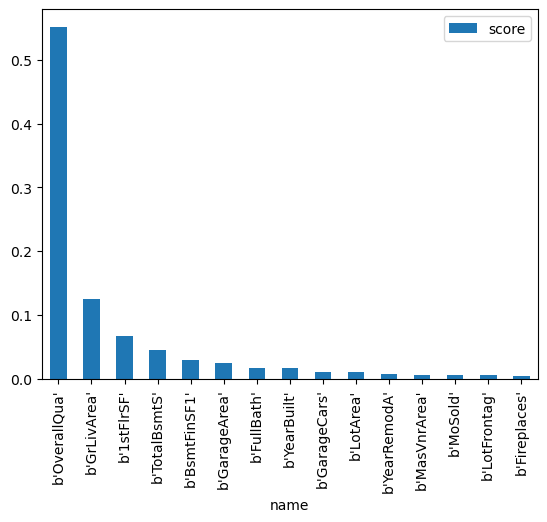

In [97]:
feature_importance = list(zip(X.columns, grid_search_RF.best_estimator_.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name,'score':score})[:15].plot.bar(x='name', y='score')

In [98]:
# bagging

grid_para_bag = [
    {
        "n_estimators": [10, 50, 100],
        "max_features": range(1, 10)},
    {
        "n_estimators": [10, 50, 100],
        "max_samples": range(1, 10)}
]

bag = ensemble.BaggingRegressor(random_state = 0)

grid_search_bag = GridSearchCV(bag, grid_para_bag, cv=5, scoring='r2', n_jobs = -1)
grid_search_bag.fit(X_train, y_train)

print("The best parameters are: ", grid_search_bag.best_params_)
print("R^2 of the training set: ", grid_search_bag.score(X_train, y_train))
print("R^2 of the final model: ", grid_search_bag.score(X_test, y_test))

The best parameters are:  {'max_samples': 9, 'n_estimators': 10}
R^2 of the training set:  0.5127281592093398
R^2 of the final model:  0.546186256974978


In [100]:
# gradient boosting

grid_para_gb = [{
        "n_estimators": [100, 300, 500],
        "learning_rate": [.0001, .001, .01, .1, .2, .3],
        "max_depth": [5, 6, 7, 8]
}]

gbm = GradientBoostingRegressor(random_state = 0)

grid_search_gbm = GridSearchCV(gbm, grid_para_gb, cv=5, scoring='r2')
%time grid_search_gbm.fit(X_train, y_train)

print("The best parameters are: ", grid_search_gbm.best_params_)
print("R^2 of the training set: ", grid_search_gbm.score(X_train, y_train))
print("R^2 of the final model: ", grid_search_gbm.score(X_test, y_test))

CPU times: user 28min 47s, sys: 6.68 s, total: 28min 53s
Wall time: 29min 28s
The best parameters are:  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
R^2 of the training set:  0.9950794092322033
R^2 of the final model:  0.9096655096339289


In [66]:
# XGBoost with tree-based model
bst = xgb.XGBRegressor(booster = 'gbtree', random_state = 0)

grid_para_xgb = [
    {
        "learning_rate": arange(0, 1.1, .1),
        "max_depth": [3, 5, 7, 9],
        "reg_lambda": [0, .3, .5, .7, 1]
    }
]

grid_search_xgb = GridSearchCV(bst, grid_para_xgb, cv=5, scoring='r2')
grid_search_xgb.fit(X_train, y_train)

print("The best parameters are: ", grid_search_xgb.best_params_)
print("R^2 of the training set: ", grid_search_xgb.score(X_train, y_train))
print("R^2 of the final model: ", grid_search_xgb.score(X_test, y_test))

The best parameters are:  {'lambda': 0, 'learning_rate': 0.1, 'max_depth': 5}
R^2 of the training set:  0.9905852109293153
R^2 of the final model:  0.9309652971024525


In [70]:
bst_tree = xgb.XGBRegressor(booster = 'gbtree', random_state = 0, 
                            reg_lambda = 0, learning_rate = .1, max_depth = 5)

cv = KFold(n_splits=10, shuffle = True, random_state = 0)
scores = cross_val_score(bst_tree, X, y, cv=cv, scoring="r2")
print(scores.mean())

0.9016246699212621


In [72]:
# XGBoost with linear model
bst = xgb.XGBRegressor(booster = 'gblinear', random_state = 0, feature_selector = 'cyclic')

grid_para_xgb = [{
        "reg_lambda": [0, .3, .5, .7, 1],
        'reg_alpha': [0, .3, .5, .7, 1]
}]

grid_search_xgb = GridSearchCV(bst, grid_para_xgb, cv=5, scoring='r2')
grid_search_xgb.fit(X_train, y_train)

print("The best parameters are: ", grid_search_xgb.best_params_)
print("R^2 of the training set: ", grid_search_xgb.score(X_train, y_train))
print("R^2 of the final model: ", grid_search_xgb.score(X_test, y_test))

The best parameters are:  {'reg_alpha': 0, 'reg_lambda': 0.3}
R^2 of the training set:  0.8806273990575962
R^2 of the final model:  0.8960993093474957


In [73]:
bst_lin = xgb.XGBRegressor(booster = 'gblinear', random_state = 0, 
                            reg_lambda = 0.3, reg_alpha = 0)

cv = KFold(n_splits=10, shuffle = True, random_state = 0)
scores = cross_val_score(bst_lin, X, y, cv=cv, scoring="r2")
print(scores.mean())

0.8697723752385947


In [ ]:
# support vector regression

svr = SVR(epsilon = 1e-4, gamma=1)
svr.fit(X,Y_noise)